# Custom Transformer

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import set_config; set_config(display='diagram')

👇 Consider the following dataset

In [93]:
import pandas as pd

data = pd.read_csv("data.csv")
data.head()
data.seller_state.unique()

array(['SP', 'SC'], dtype=object)

- Each observation of the dataset represents an item being delivered from a  `seller_state` to a `customer_state`. 
- Other columns describe the packaging properties of each item.

🎯 The target is the number of days between the order and the delivery.

<AxesSubplot:xlabel='days_until_delivery', ylabel='Count'>

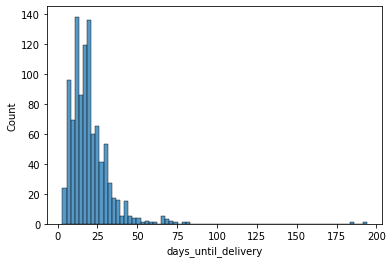

In [3]:
# Check target
sns.histplot(data.days_until_delivery)

In [28]:
X = data.drop(columns='days_until_delivery')
y = data['days_until_delivery']

## 1. Pipeline

👇 Create a scikit-learn pipeline named `pipe`:

- Engineer a `volume` feature from the dimensions features
- Preserve the original product dimensions features for training
- Scale all numerical features
- Encode the categorical features
- Add a default `Ridge` regression estimator

<details><summary>Hints</summary>

- There are many ways to create your preprocessed matrix (using `ColumnTransformer` and/or `FeatureUnion`). 
    
- If your transformed feature matrix look wierd, it may be stored as "sparse" by the default behavior of `OneHotEncoder(sparse=True)`. Use `.todense()` to turn it back to a dense matrix

</details>

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import FeatureUnion
from sklearn.compose import make_column_selector
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

In [14]:
lambda df: pd.DataFrame(df['product_length_cm']*df['product_height_cm']*df['product_width_cm'])

<function __main__.<lambda>(df)>

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   customer_state       1000 non-null   object
 1   seller_state         1000 non-null   object
 2   product_weight_g     1000 non-null   int64 
 3   product_length_cm    1000 non-null   int64 
 4   product_height_cm    1000 non-null   int64 
 5   product_width_cm     1000 non-null   int64 
 6   days_until_delivery  1000 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 54.8+ KB


In [94]:
vol = FunctionTransformer(lambda df: pd.DataFrame( \
                    df['product_length_cm']*df['product_height_cm']*df['product_width_cm'], columns=['volume_cm3']))


num_col = make_column_selector(dtype_include=['float64','int64'])

cat_col = make_column_selector(dtype_include=['object','bool'])

#num_transformer = make_pipeline(vol,RobustScaler())
num_transformer = make_pipeline(RobustScaler())
cat_transformer = make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore'))
vol_transformer = make_pipeline(vol,RobustScaler())

col_trans = ColumnTransformer([("num_t",num_transformer,num_col),
                              ("cat_t",cat_transformer,cat_col),
                              ("vol_t",vol_transformer,num_col)])

col_trans

ColumnTransformer(transformers=[('num_t',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14ea66190>),
                                ('cat_t',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14ea660d0>),
                                ('vol_t',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function <lambda> at 0x14ec72040>)),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14ea66190>)])

In [96]:
pipe = make_pipeline(col_trans,Ridge())

#### 🧪 Test your pipe

In [86]:
from nbresult import ChallengeResult

pipe_test = pipe

# Check that it doesn't crash
assert pipe_test.fit(X,y)

result = ChallengeResult('pipe', 
                         shape = pipe_test[:-1].fit_transform(X).shape
)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/humbert/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/humbert/code/HumbertMonnot/data-challenges/05-ML/08-Workflow/02-Custom-Transformer
plugins: anyio-3.4.0, dash-2.0.0
collecting ... collected 1 item

tests/test_pipe.py::TestPipe::test_pipe_not_crashing PASSED              [100%]

============================== 1 passed in 0.36s ===============================


💯 You can commit your code:

git add tests/pipe.pickle

git commit -m 'Completed pipe step'

git push origin master


## 2. Train and Predict

👇 Let's imagine `data` is your entire training set.

- `cross_validate` your pipeline on this dataset (❗️low r2 score are expected)
- Now, imagine you just received an new order `new_data`: predict it's duration of delivery in a variable `prediction`

In [97]:
X_transform = col_trans.fit_transform(X)

In [98]:
display(pd.DataFrame(X_transform).head(3))

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-0.660217,0.0,-1.000000,0.642857,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.556110
1,-0.768520,1.0,-0.804878,-0.214286,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.344725
2,-0.660217,0.0,-1.000000,0.642857,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.556110


In [89]:
new_data = pd.read_csv("data_new.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


In [100]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipe,X,y,scoring='r2').mean()

0.1247286014145194

In [103]:
pipe.fit(X,y)
prediction = pipe.predict(new_data)
prediction

array([20.69440244])

In [104]:
from nbresult import ChallengeResult

result = ChallengeResult('prediction',
    prediction = prediction
)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /Users/humbert/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/humbert/code/HumbertMonnot/data-challenges/05-ML/08-Workflow/02-Custom-Transformer
plugins: anyio-3.4.0, dash-2.0.0
collecting ... collected 1 item

tests/test_prediction.py::TestPrediction::test_prediction PASSED         [100%]

============================== 1 passed in 0.36s ===============================


💯 You can commit your code:

git add tests/prediction.pickle

git commit -m 'Completed prediction step'

git push origin master


🏁 Congratulation. Don't forget to add, commit and push your notebook.